# Phone Prices SVR

## Libraries

In [89]:
import pandas as pd
from sklearn.preprocessing import TargetEncoder, StandardScaler
from datetime import datetime
from sklearn.feature_selection import mutual_info_regression, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

## Preprocessing

### The dataset

In [90]:
data = pd.read_csv("../CSVs Cleaned/Cleaned cleaned_all_phones.csv")
print(data.head())
y = data['price']

    brand           os  inches  battery battery_type  ram(GB)  \
0  Huawei  Android 5.1     5.0     2200        Li-Po        2   
1      LG  Android 7.0     5.3     2700       Li-Ion        2   
2  Huawei  Android 7.0     5.2     3000       Li-Ion        4   
3  Xiaomi  Android 6.0     5.5     4100        Li-Po        4   
4  Huawei  Android 7.0     5.1     3200       Li-Ion        4   

  announcement_date  weight(g)  storage(GB)  video_720p  ...  video_120fps  \
0        2016-09-01      140.0           16        True  ...         False   
1        2016-12-01      140.0           16       False  ...         False   
2        2017-01-01      147.0           16       False  ...         False   
3        2017-01-01      165.0           32        True  ...          True   
4        2017-02-01      145.0           32        True  ...         False   

   video_240fps  video_480fps  video_960fps  price  resolution_height  \
0         False         False         False  120.0                7

Using TargetEncoder to encode categorical features

In [ ]:
encoder = TargetEncoder(target_type="continuous")
data['brand_encoded'] = encoder.fit_transform(data[['brand']], y)
data['battery_type_encoded'] = encoder.fit_transform(data[['battery_type']], y)
data['os_encoded'] = encoder.fit_transform(data[['os_brands']], y)

data['announcement_year'] = pd.Series(data['announcement_date']).apply(lambda x: datetime.fromisoformat(x).year)
data['announcement_month'] = pd.Series(data['announcement_date']).apply(lambda x: datetime.fromisoformat(x).month)
data['announcement_day'] = pd.Series(data['announcement_date']).apply(lambda x: datetime.fromisoformat(x).day)
del data['announcement_date']
del data['brand']
del data['battery_type']
del data['os']
del data['os_brands']
del data['resolution_height']
del data['resolution_width']

print(data.head())

   inches  battery  ram(GB)  weight(g)  storage(GB)  video_720p  video_1080p  \
0     5.0     2200        2      140.0           16        True        False   
1     5.3     2700        2      140.0           16       False         True   
2     5.2     3000        4      147.0           16       False         True   
3     5.5     4100        4      165.0           32        True         True   
4     5.1     3200        4      145.0           32        True         True   

   video_4K  video_8K  video_30fps  ...  video_960fps  price  resolution  \
0     False     False         True  ...         False  120.0      921600   
1     False     False         True  ...         False  100.0      921600   
2     False     False         True  ...         False  420.0     2073600   
3     False     False         True  ...         False  150.0     2073600   
4      True     False         True  ...         False  420.0     2073600   

          ppi  brand_encoded  battery_type_encoded  os_encoded

Drop samples with empty columns and separate features from target feature, price. Then select the top 10 features based on their mutual information (nat) score.

In [92]:
data = data.dropna()

y = data['price']
X = data.drop('price', axis=1)

mutual_info = mutual_info_regression(X, y)

# Create a DataFrame for better visualization
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': mutual_info,
}).sort_values(by='Score', ascending=False)

# Display the feature importance scores
print(feature_scores)

select = SelectKBest(mutual_info_regression, k=10).fit(X, y)
X = select.transform(X)
print(f"\nSelected Features: {select.get_feature_names_out()}")

                 Feature     Score
15            resolution  0.150429
16                   ppi  0.142685
4            storage(GB)  0.115265
5             video_720p  0.101613
7               video_4K  0.098852
2                ram(GB)  0.094446
0                 inches  0.082564
10           video_60fps  0.079283
20     announcement_year  0.070626
1                battery  0.067025
17         brand_encoded  0.066221
22      announcement_day  0.056805
11          video_120fps  0.041483
8               video_8K  0.036911
3              weight(g)  0.034980
14          video_960fps  0.030939
12          video_240fps  0.028464
13          video_480fps  0.012819
6            video_1080p  0.012731
9            video_30fps  0.011041
19            os_encoded  0.010182
21    announcement_month  0.003192
18  battery_type_encoded  0.000000

Selected Features: ['inches' 'battery' 'ram(GB)' 'storage(GB)' 'video_720p' 'video_4K'
 'resolution' 'ppi' 'brand_encoded' 'announcement_day']


## Training and testing

Scaling features

In [93]:
sc_X = StandardScaler()
sc_y = StandardScaler()
scaled_X = sc_X.fit_transform(X)
scaled_y = sc_y.fit_transform(y.to_numpy().reshape(-1, 1))

Split the dataset into test data and training data

In [94]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, scaled_y, test_size=0.1)

Fit the training data to the model, and test by performing predictions on the test data

In [95]:
from sklearn.svm import SVR
regressor = SVR()
regressor.fit(X_train, y_train)

pred = regressor.predict(X_test)
pred = pd.DataFrame(pred)

# Revert scaled values to price information
predicted_price = sc_y.inverse_transform(pred)
real_price = sc_y.inverse_transform(y_test)

c:\Users\andre\Documents\GitHub\Mobile-Phone-Price-Prediction\.venv\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Summarize performance

Train coeff of determination: 0.32278230303979816
Test coeff of determination: 0.10432475367435123
MAE: $103.05516334406784
MAPE: 0.36264304692856403


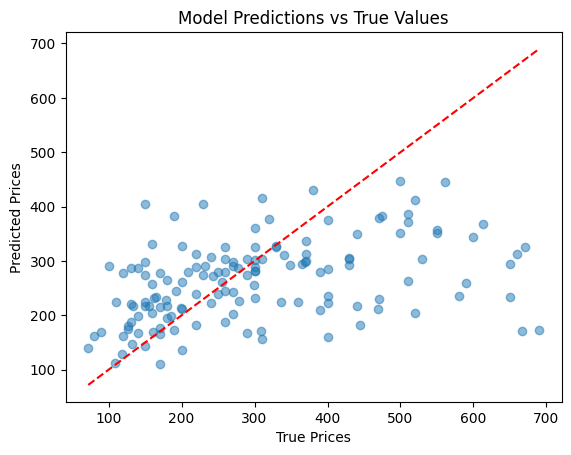

In [96]:
print(f"Train coeff of determination: {regressor.score(X_train, y_train)}")
print(f"Test coeff of determination: {regressor.score(X_test, y_test)}")
print(f"MAE: ${mean_absolute_error(real_price, predicted_price)}")
print(f"MAPE: {mean_absolute_percentage_error(real_price, predicted_price)}")

import matplotlib.pyplot as plt
plt.scatter(real_price, predicted_price, alpha=0.5)
plt.plot([min(real_price), max(real_price)], [min(real_price), max(real_price)], 'r--')
plt.xlabel("True Prices")
plt.ylabel("Predicted Prices")
plt.title("Model Predictions vs True Values")
plt.show()